<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET_1 = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
TARGET_2 = 'btc_logret'

In [9]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [10]:
total_len = len(df)

In [11]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [12]:
train_df.shape

(2629, 29)

In [13]:
val_df.shape

(564, 29)

In [14]:
test_df.shape

(564, 29)

# Scaling

In [15]:
scaler_1 = MinMaxScaler()

In [16]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [17]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1 = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1 = scaler_1.transform(test_df[FEATURES_1])

In [18]:
scaler_2 = MinMaxScaler()

In [19]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [20]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2 = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2 = scaler_2.transform(test_df[FEATURES_2])

# GRU Sequence Data

In [21]:
def make_sequence_data(values, target, lookback):
  X, y = [], []

  for i in range(lookback, len(values)):
    X.append(values[i-lookback:i])
    y.append(target[i])

  return np.array(X), np.array(y)

In [22]:
LOOKBACK = 60

In [23]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, train_df[TARGET_1].values, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, val_df[TARGET_1].values, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, test_df[TARGET_1].values, LOOKBACK)

X_train_2, y_train_2 = make_sequence_data(train_scaled_2, train_df[TARGET_2].values, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, val_df[TARGET_2].values, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, test_df[TARGET_2].values, LOOKBACK)

# Metrics

In [24]:
def calculate_performance_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    da = np.mean((y_test * y_pred) > 0)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [25]:
from itertools import product

In [26]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.005],
    "batch_size": [32, 64],
    "dropout": [0.0, 0.2],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["dropout"],
    GRID["patience"]
))

In [27]:
len(grid_combinations)

32

In [28]:
def build_gru(input_shape, units, dropout, learning_rate):
  model = models.Sequential([
      layers.GRU(units, return_sequences=True, input_shape=input_shape),
      layers.GRU(units),
      layers.Dropout(dropout),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
      loss='mse'
  )
  return model

In [29]:
results = []

In [30]:
for i, (units, lr, batch_size, dropout, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, batch={batch_size}, "
        f"dropout={dropout}, patience={patience}")

  ## WITHOUT MACRO
  model_1 = build_gru(X_train_1.shape[1:], units, dropout, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_1, y_val_1),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
      ],
      verbose=0
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  ## WITH MACRO
  model_2 = build_gru(X_train_2.shape[1:], units, dropout, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_2, y_val_2),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
      ],
      verbose=0
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "dropout": dropout,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Results

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,units,learning_rate,batch_size,dropout,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,50,0.001,32,0.0,5,0.000575,0.000718,0.023977,0.026803,0.017388,0.019840,0.511905,0.462302,False,False,False,False
1,50,0.001,32,0.0,10,0.001163,0.001312,0.034103,0.036219,0.028308,0.030453,0.488095,0.488095,False,False,False,False
2,50,0.001,32,0.2,5,0.000567,0.000563,0.023810,0.023729,0.017147,0.017000,0.511905,0.511905,True,True,True,False
3,50,0.001,32,0.2,10,0.000563,0.000746,0.023723,0.027307,0.017108,0.021059,0.515873,0.500000,False,False,False,False
4,50,0.001,64,0.0,5,0.000906,0.006840,0.030093,0.082704,0.024113,0.071884,0.488095,0.488095,False,False,False,False
5,50,0.001,64,0.0,10,0.000674,0.000683,0.025964,0.026129,0.019752,0.019561,0.500000,0.480159,False,False,True,False
6,50,0.001,64,0.2,5,0.000577,0.000560,0.024029,0.023663,0.017303,0.016935,0.509921,0.511905,True,True,True,True
7,50,0.001,64,0.2,10,0.000560,0.000599,0.023667,0.024471,0.016934,0.017898,0.511905,0.486111,False,False,False,False
8,50,0.005,32,0.0,5,0.000564,0.001116,0.023745,0.033407,0.017068,0.027456,0.511905,0.503968,False,False,False,False
9,50,0.005,32,0.0,10,0.000563,0.002274,0.023723,0.047684,0.017030,0.040045,0.511905,0.488095,False,False,False,False


In [ ]:
results_df.to_csv('gru_grid_results.csv') # Retraining the model is optional

In [ ]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [ ]:
best_without_macro

,26
units,100
learning_rate,0.005
batch_size,32
dropout,0.2
patience,5
MSE_1,0.000559
MSE_2,0.000563
RMSE_1,0.023641
RMSE_2,0.023721
MAE_1,0.016896


In [ ]:
best_with_macro

,14
units,50
learning_rate,0.005
batch_size,64
dropout,0.2
patience,5
MSE_1,0.000563
MSE_2,0.000559
RMSE_1,0.023728
RMSE_2,0.02365
MAE_1,0.01706


In [ ]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [ ]:
macro_mse_win_rate

np.float64(0.375)

In [ ]:
macro_mae_win_rate

np.float64(0.4375)

In [ ]:
macro_da_win_rate

np.float64(0.125)

# Retrain for Plotting

In [30]:
model_1 = build_gru(X_train_1.shape[1:], 100, 0.2, 0.005)

history_best_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_1, y_val_1),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

y_pred_1 = model_1.predict(X_test_1).ravel()

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0124 - val_loss: 6.0271e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0016 - val_loss: 6.0316e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0016 - val_loss: 6.0479e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0016 - val_loss: 6.0179e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0016 - val_loss: 6.0103e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0016 - val_loss: 6.0124e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0016 - val_loss: 6.0153e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0017 - val_loss: 6.0228e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0016 - val_loss: 6.0324e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0016 - val_loss: 6.0450e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [31]:
model_2 = build_gru(X_train_2.shape[1:], 50, 0.2, 0.005)

history_best_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_2, y_val_2),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

y_pred_2 = model_2.predict(X_test_2).ravel()

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0365 - val_loss: 6.6657e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0019 - val_loss: 6.0218e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0017 - val_loss: 6.0130e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0017 - val_loss: 6.0116e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0017 - val_loss: 6.0126e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0017 - val_loss: 6.0162e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0017 - val_loss: 6.0114e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0017 - val_loss: 6.0096e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0017 - val_loss: 6.0119e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0017 - val_loss: 6.0076e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0017 - val_loss: 6.0101e-04
Epoch 12/50
41/41 

# Plotting

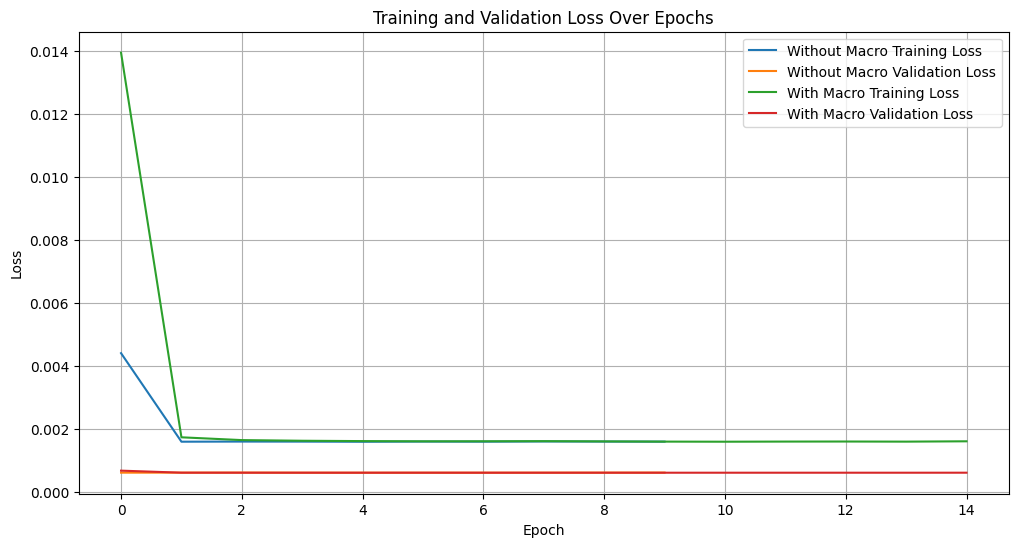

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history_best_without_macro.history['loss'], label='Without Macro Training Loss')
plt.plot(history_best_without_macro.history['val_loss'], label='Without Macro Validation Loss')
plt.plot(history_best_with_macro.history['loss'], label='With Macro Training Loss')
plt.plot(history_best_with_macro.history['val_loss'], label='With Macro Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

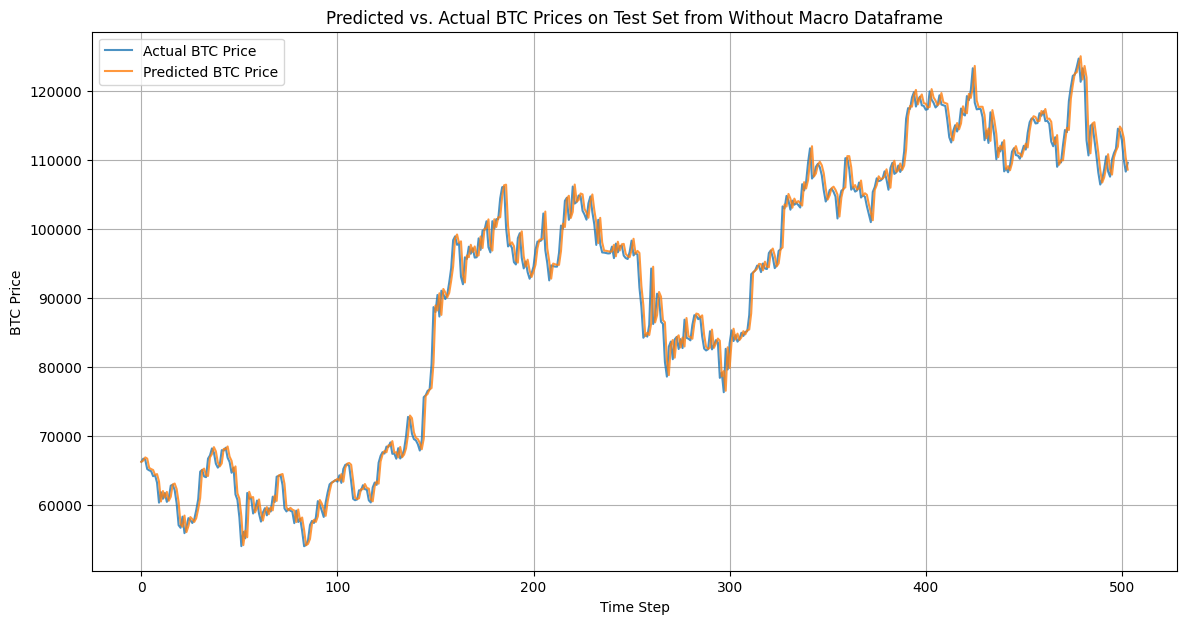

In [33]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_1)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('Predicted vs. Actual BTC Prices on Test Set from Without Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()

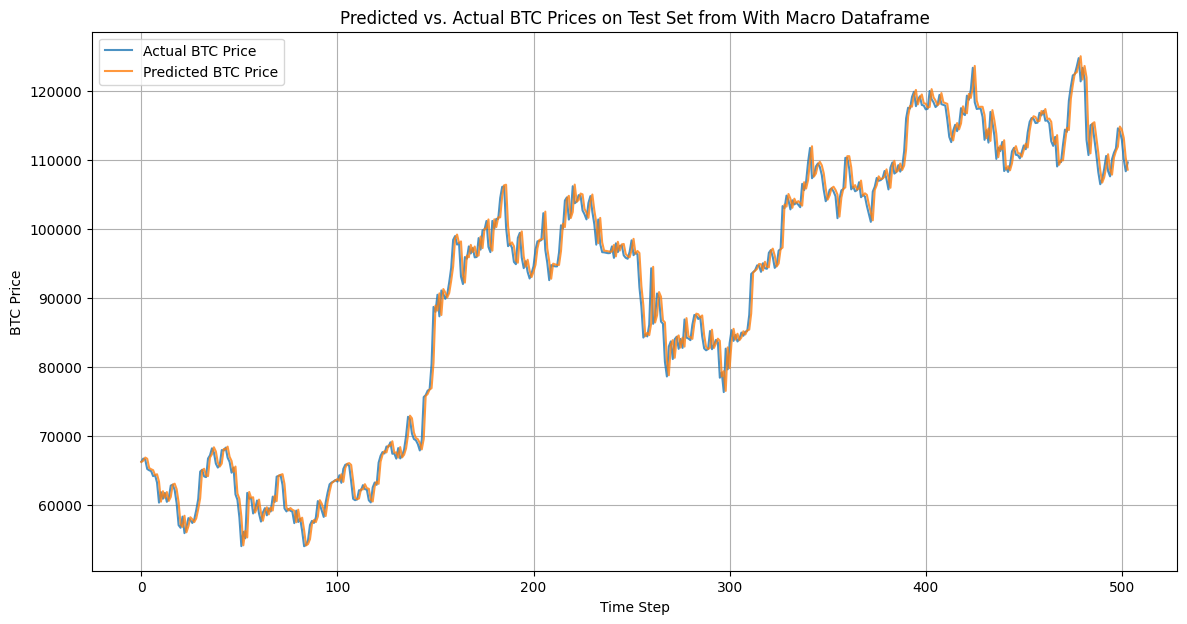

In [34]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_2)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('Predicted vs. Actual BTC Prices on Test Set from With Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()

# Statistical Significance Test

In [35]:
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

In [36]:
def per_timestep_squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2

def hac_test_loss_difference(loss_diff, max_lag=5):
    X = np.ones(len(loss_diff))  # intercept only
    model = sm.OLS(loss_diff, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": max_lag}
    )
    return {
        "p_value": model.pvalues[0]
    }

def mcnemar_direction_test(y_true, y_pred_nomacro, y_pred_macro):
    correct_nomacro = np.sign(y_true) == np.sign(y_pred_nomacro)
    correct_macro = np.sign(y_true) == np.sign(y_pred_macro)

    table = [
        [np.sum(correct_macro & correct_nomacro),
         np.sum(correct_macro & ~correct_nomacro)],
        [np.sum(~correct_macro & correct_nomacro),
         np.sum(~correct_macro & ~correct_nomacro)]
    ]

    result = mcnemar(table, correction=True)
    return {
        "p_value": result.pvalue
    }

In [37]:
loss_nomacro = per_timestep_squared_error(y_test_1, y_pred_1)
loss_macro   = per_timestep_squared_error(y_test_2, y_pred_2)

loss_diff = loss_macro - loss_nomacro

In [38]:
hac_result = hac_test_loss_difference(loss_diff, max_lag=5)

print(f"p-value: {hac_result['p_value']:.4f}")

p-value: 0.1472


In [39]:
da_test = mcnemar_direction_test(y_test_1, y_pred_1, y_pred_2)

print(f"p-value: {da_test['p_value']:.4f}")

p-value: 1.0000


# Post-Hoc Stastical Tests

In [40]:
predicted_btc_prices_1 = previous_btc_prices * np.exp(y_pred_1)
predicted_btc_prices_2 = previous_btc_prices * np.exp(y_pred_2)

In [41]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values

In [42]:
err_no_macro = predicted_btc_prices_1 - actual_btc_prices

In [43]:
err_macro = predicted_btc_prices_2 - actual_btc_prices

In [44]:
abs_err_no_macro = np.abs(err_no_macro)

In [45]:
abs_err_macro = np.abs(err_macro)

WMAE

In [46]:
test_logret = test_df['btc_logret'].iloc[LOOKBACK:].values

In [47]:
rolling_vol_60 = (
    pd.Series(test_logret).rolling(window=60).std().values
)

In [48]:
valid_idx = ~np.isnan(rolling_vol_60)

In [49]:
wmae_no_macro = np.sum(abs_err_no_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])
wmae_macro = np.sum(abs_err_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])

In [50]:
print(f"WMAE (No Macro): {wmae_no_macro:.6f}")
print(f"WMAE (With Macro): {wmae_macro:.6f}")
print(f"ΔWMAE: {wmae_macro - wmae_no_macro:.6f}")

WMAE (No Macro): 1529.472279
WMAE (With Macro): 1524.435526
ΔWMAE: -5.036753


Distributional Properties of Errors

In [51]:
def distribution_stats(errors):
  return {
      "mean": np.mean(errors),
      "median": np.median(errors),
      "std": np.std(errors),
      "iqr": np.percentile(errors, 75) - np.percentile(errors, 25),
      "min": np.min(errors),
      "max": np.max(errors)
  }

In [52]:
dist_no_macro = distribution_stats(err_no_macro)

In [53]:
dist_macro = distribution_stats(err_macro)

In [54]:
dist_df = pd.DataFrame([dist_no_macro, dist_macro], index=['No Macro', 'With Macro'])

In [55]:
dist_df

,mean,median,std,iqr,min,max
No Macro,160.954819,212.349122,2054.464111,2066.769168,-8056.330096,9119.560377
With Macro,115.153356,163.363418,2053.630201,2046.391319,-8096.923921,9058.122478


Per-Model Macro Effect

In [56]:
gru_stat_results = {
    "model": "GRU",
    "wmae_no_macro": wmae_no_macro,
    "wmae_macro": wmae_macro,
    "delta_wmae": wmae_macro - wmae_no_macro,
    "std_err_no_macro": dist_no_macro["std"],
    "std_err_macro": dist_macro["std"]
}

In [57]:
gru_stat_results

{'model': 'GRU',
 'wmae_no_macro': np.float64(1529.4722791668619),
 'wmae_macro': np.float64(1524.4355257730688),
 'delta_wmae': np.float64(-5.036753393793106),
 'std_err_no_macro': np.float64(2054.4641112559552),
 'std_err_macro': np.float64(2053.6302007700087)}

In [58]:
pd.DataFrame([gru_stat_results]).to_csv("gru_statistical_results.csv", index=False)

# Error Visualization

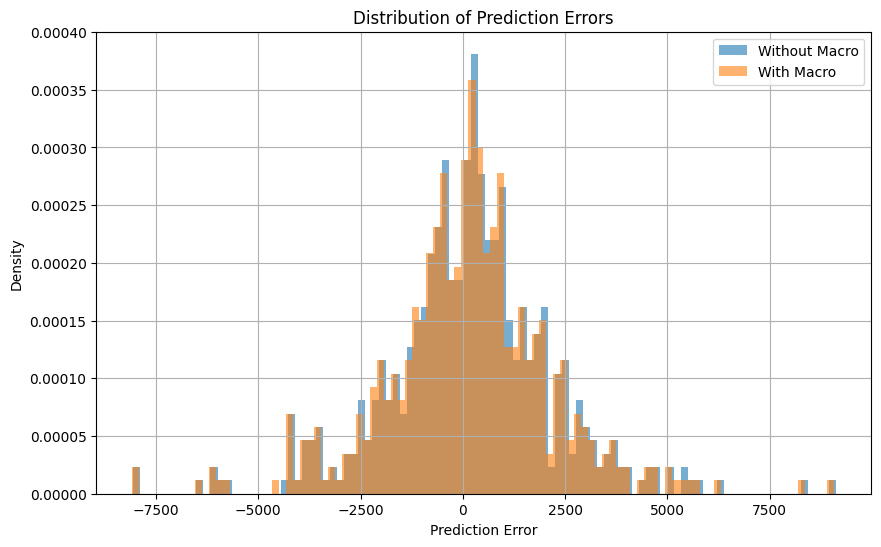

In [59]:
plt.figure(figsize=(10,6))
plt.hist(err_no_macro, bins=100, alpha=0.6, label='Without Macro', density=True)
plt.hist(err_macro, bins=100, alpha=0.6, label='With Macro', density=True)

plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True)

plt.show()

/tmp/ipython-input-3840640867.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


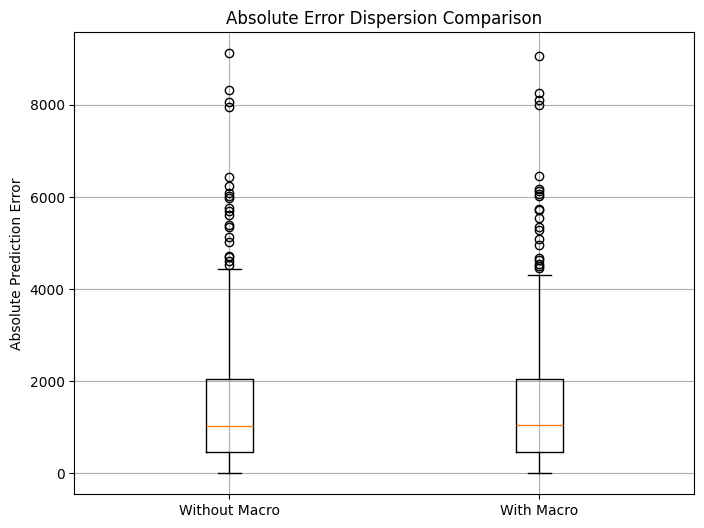

In [60]:
plt.figure(figsize=(8, 6))

plt.boxplot(
    [abs_err_no_macro, abs_err_macro],
    labels=['Without Macro', 'With Macro'],
    showfliers=True
)

plt.ylabel('Absolute Prediction Error')
plt.title('Absolute Error Dispersion Comparison')
plt.grid(True)

plt.show()

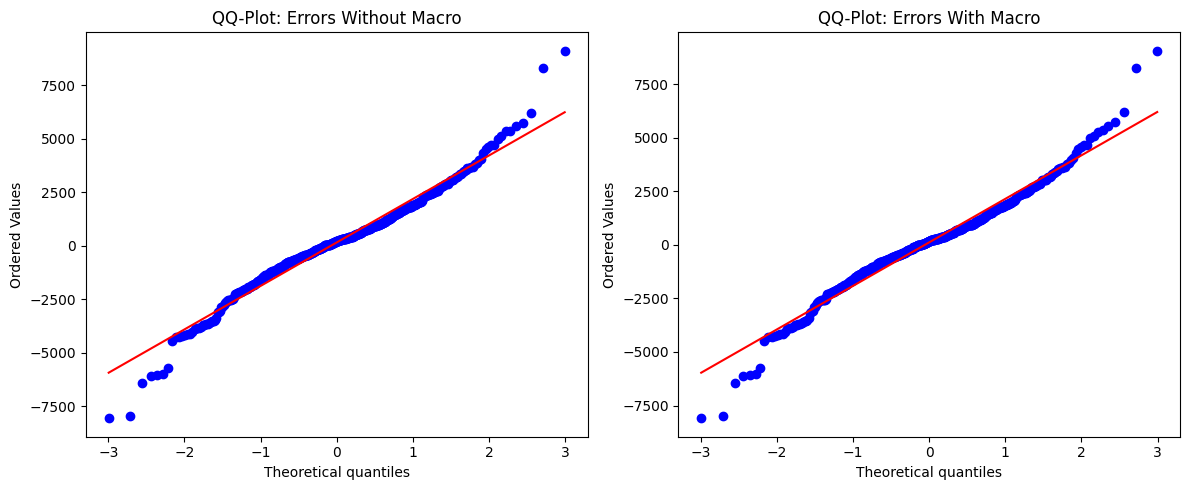

In [61]:
import scipy.stats as stats

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(err_no_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors Without Macro')

plt.subplot(1, 2, 2)
stats.probplot(err_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors With Macro')

plt.tight_layout()
plt.show()